In [325]:
import os
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.spatial import procrustes
from scipy.spatial.transform import Rotation as R
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

In [326]:
# TODO: outlier detection and removal
# TODO: run all subjects
# TODO: plot racket plane over trajectory
# TODO: think about rotation..

In [327]:
data_path = "C:\\Users\\flipe\\AppData\\LocalLow\\Warehouse\\VR-tennis\\Data"
subject_paths = [f.name for f in os.scandir(data_path) if f.is_dir()]
subject_count = len(subject_paths)

In [ ]:
subject2plot = "Simon"
features2compare = [
    "centereyeanchor",
    "racket-grip-base",
    "racket-stringbed-center",
    "ball-tracker",
]
features2compare_labels = ["head", "grip", "strings", "ball"]
feature_colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
feature_count = len(features2compare)

In [329]:
alignment = "RacketHit"
window_duration = 0.5  # seconds
half_window_duration = window_duration / 2
window_size = int(window_duration * 500) + 1
window_time = np.linspace(-half_window_duration, half_window_duration, num=window_size)

In [330]:
useHeadCentricCorrections = True

In [331]:
# List CSV files in each subject directory
for subject in subject_paths:
    subject_dir = os.path.join(data_path, subject)
    csv_files = [f for f in os.listdir(subject_dir) if f.endswith(".csv")]
    print(f"Subject: {subject}")
    print("CSV files:", csv_files)
    print("-" * 40)

# Find the subject directory that matches subject2plot
subject_dir_match = [s for s in subject_paths if subject2plot in s]
if subject_dir_match:
    subject_dir = os.path.join(data_path, subject_dir_match[0])
    csv_files = [f for f in os.listdir(subject_dir) if f.endswith(".csv")]
    dfs_features = {}
    for feature in features2compare:
        csv_to_read = [f for f in csv_files if feature in f]
        if csv_to_read:
            csv_path = os.path.join(subject_dir, csv_to_read[0])
            label = features2compare_labels[features2compare.index(feature)]
            dfs_features[label] = pd.read_csv(csv_path)
            print(f"Loaded {csv_to_read[0]} for subject {subject2plot}")
            print(dfs_features[label].head())
        else:
            print(f"No CSV file found for feature: {feature} in subject {subject2plot}")
else:
    print(f"No subject directory found for: {subject2plot}")

Subject: Charline_R_vr3_3_2025-06-23_15-12-35
CSV files: ['name_age_sex_tennis-exp_vr-exp_ball-tracker.csv', 'name_age_sex_tennis-exp_vr-exp_centereyeanchor.csv', 'name_age_sex_tennis-exp_vr-exp_lefthandanchor.csv', 'name_age_sex_tennis-exp_vr-exp_racket-frame-base.csv', 'name_age_sex_tennis-exp_vr-exp_racket-frame-left.csv', 'name_age_sex_tennis-exp_vr-exp_racket-frame-right.csv', 'name_age_sex_tennis-exp_vr-exp_racket-frame-top.csv', 'name_age_sex_tennis-exp_vr-exp_racket-grip-base.csv', 'name_age_sex_tennis-exp_vr-exp_racket-stringbed-center.csv', 'name_age_sex_tennis-exp_vr-exp_righthandanchor.csv']
----------------------------------------
Subject: FilipeMendes_R_vr8_4_2025-06-24_11-07-13
CSV files: ['name_age_sex_tennis-exp_vr-exp_ball-tracker.csv', 'name_age_sex_tennis-exp_vr-exp_centereyeanchor.csv', 'name_age_sex_tennis-exp_vr-exp_lefthandanchor.csv', 'name_age_sex_tennis-exp_vr-exp_racket-frame-base.csv', 'name_age_sex_tennis-exp_vr-exp_racket-frame-left.csv', 'name_age_sex_te

In [332]:
time2exclude = 60

# Exclude data before a certain time for both features in dfs_features
for label in dfs_features:
    mask = dfs_features[label]["time"] >= time2exclude
    dfs_features[label].loc[
        ~mask, dfs_features[label].columns.difference(["time"])
    ] = np.nan

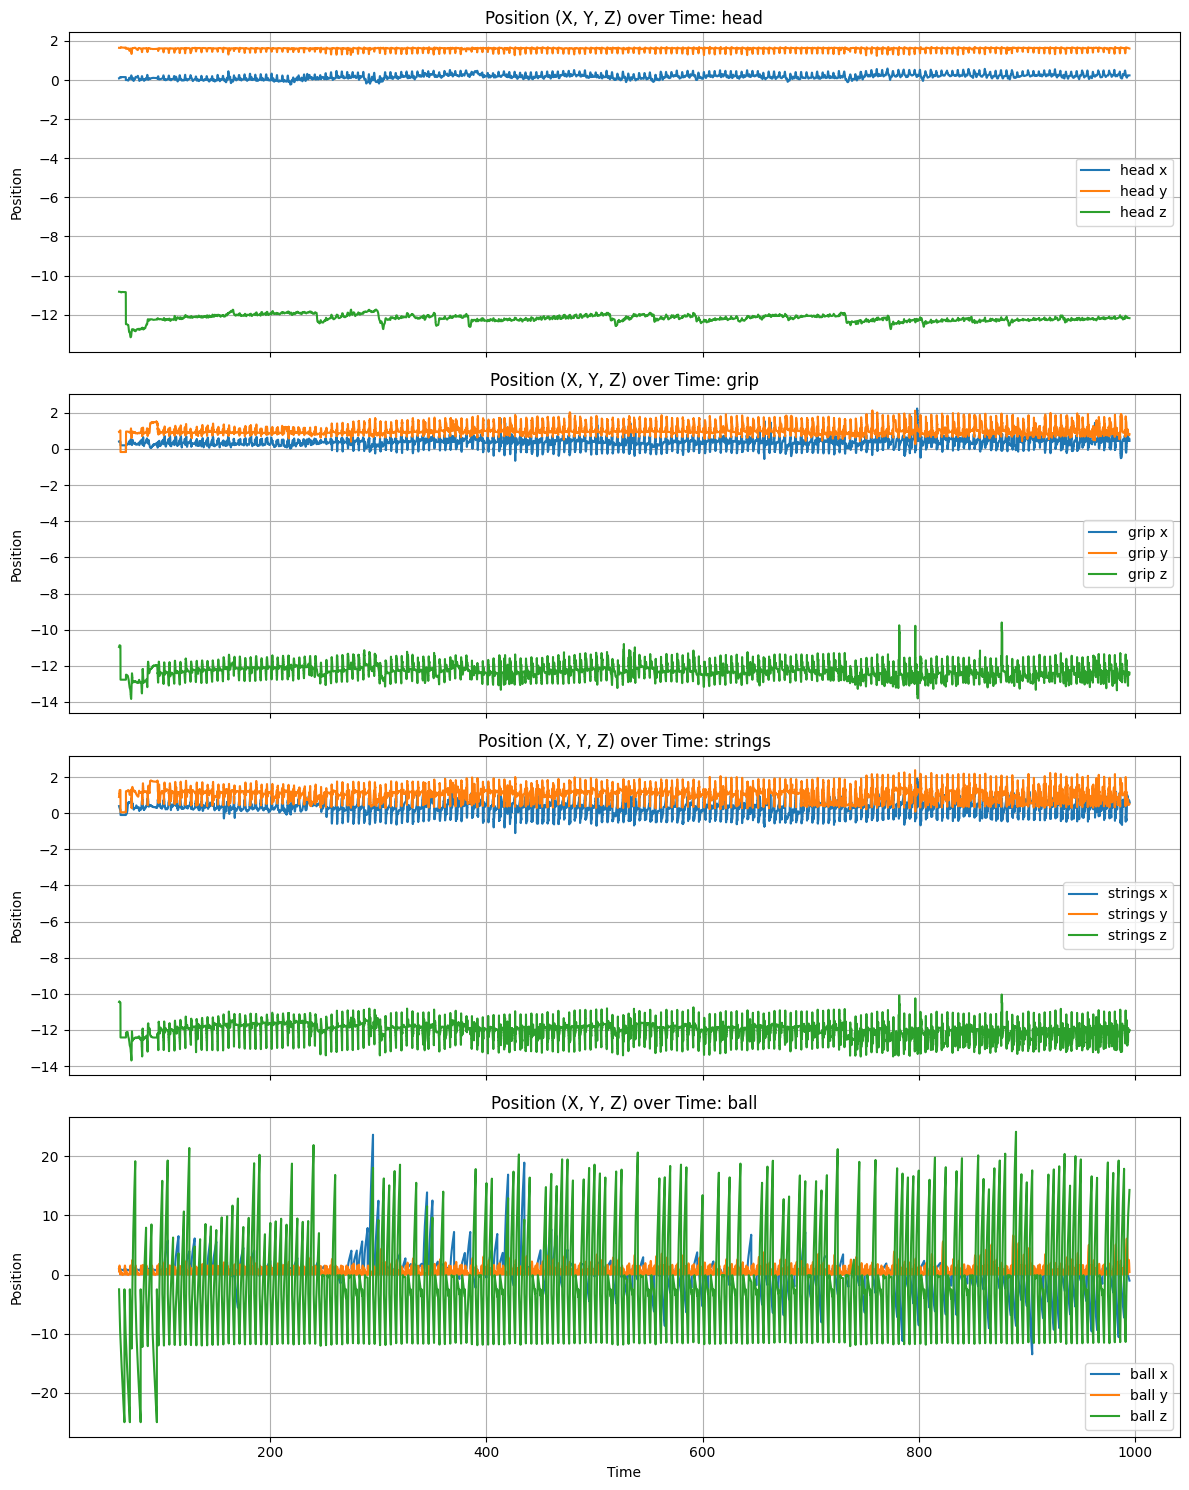

In [333]:
fig, axs = plt.subplots(feature_count, 1, figsize=(12, 15), sharex=True)

for i, label in enumerate(dfs_features):
    df = dfs_features[label]
    axs[i].plot(df["time"], df["position.x"], label=f"{label} x")
    axs[i].plot(df["time"], df["position.y"], label=f"{label} y")
    axs[i].plot(df["time"], df["position.z"], label=f"{label} z")
    axs[i].set_ylabel("Position")
    axs[i].set_title(f"Position (X, Y, Z) over Time: {label}")
    axs[i].legend()
    axs[i].grid()

axs[-1].set_xlabel("Time")
plt.tight_layout()
plt.show()

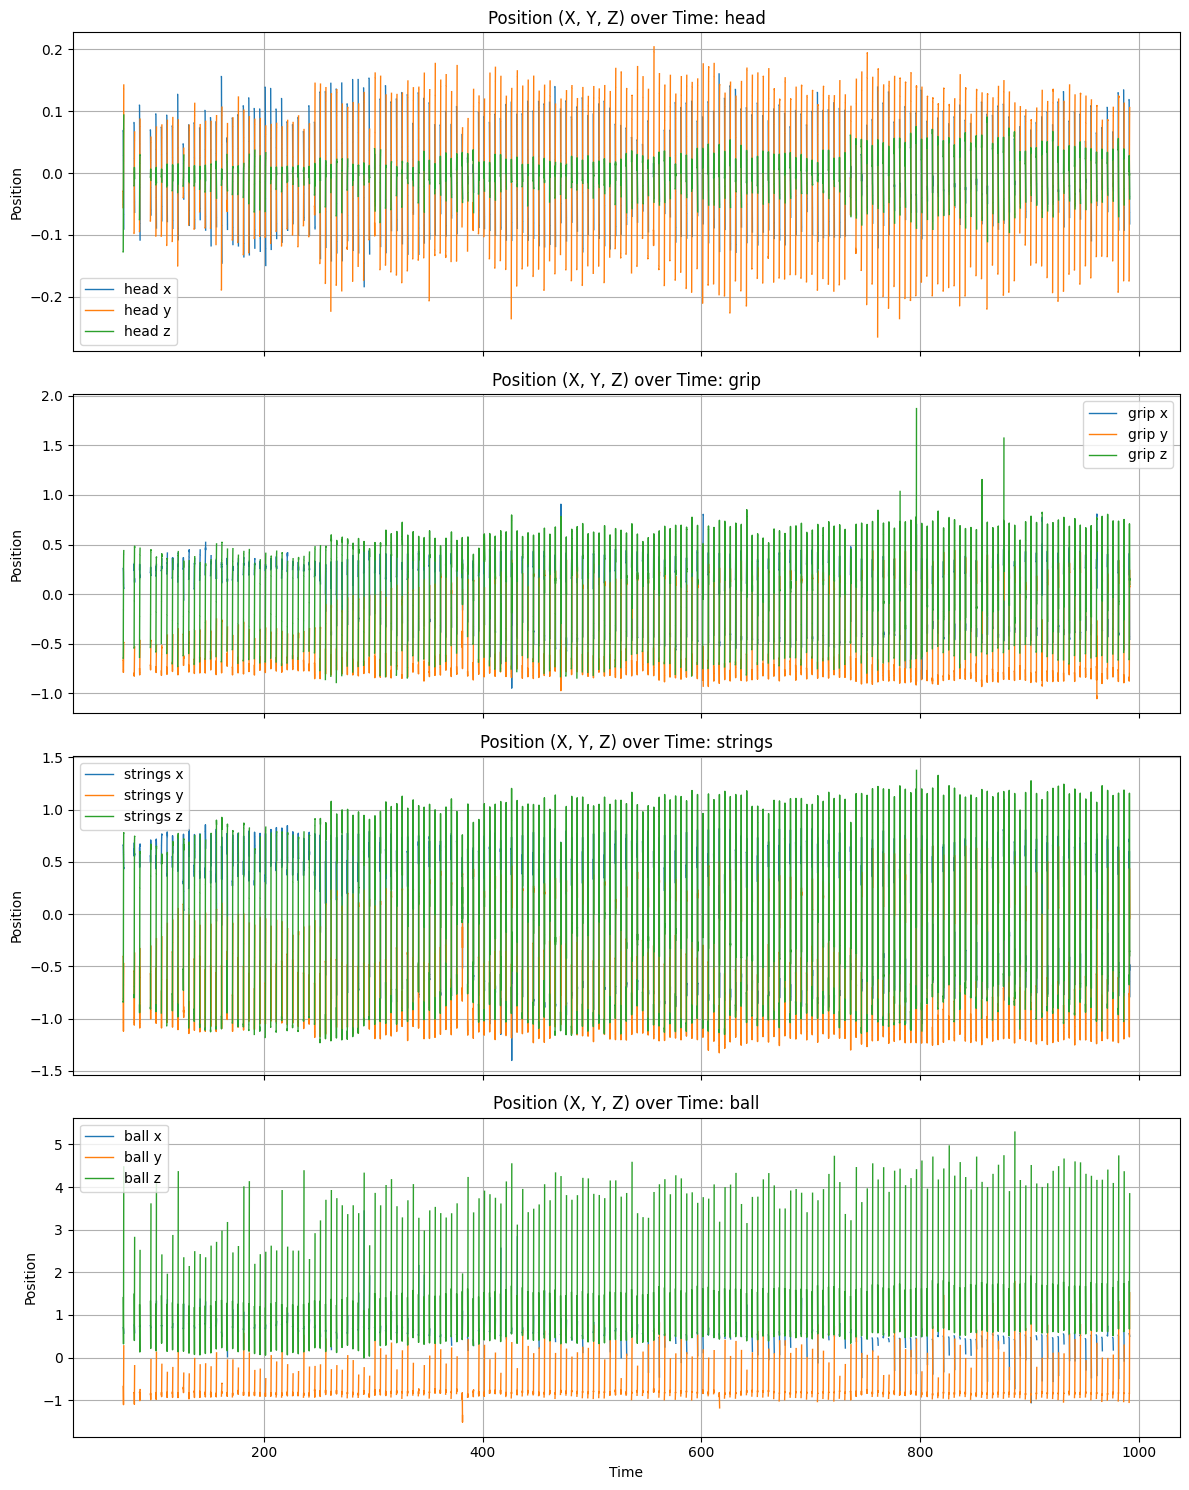

In [334]:
# Create a deep copy of dfs_features to store the modified data
dfs_features_sub = copy.deepcopy(dfs_features)

# Set all values except 'time' to NaN in dfs_features2
for label in dfs_features_sub:
    cols_to_nan = [
        col
        for col in dfs_features_sub[label].columns
        if col.startswith("position.") or col.startswith("rotation.")
    ]
    dfs_features_sub[label][cols_to_nan] = np.nan

# Use the head feature as reference for position
df_ref = copy.deepcopy(dfs_features["head"])

# Iterate through all racket hits, compute the mean for each coordinate and each feature on a 1000 ms window, and subtract it from the corresponding snippets
for label in dfs_features:
    df_feat = dfs_features[label]
    hit_times = df_feat[df_feat["event"] == alignment]["time"].values

    for t_hit in hit_times:

        # Get indices for the window around the hit
        mask = (df_feat["time"] >= t_hit - half_window_duration) & (
            df_feat["time"] <= t_hit + half_window_duration
        )
        idx = df_feat.index[mask]

        # Subtract the mean from the corresponding snippets
        if useHeadCentricCorrections:
            if label in ["head", "grip", "strings", "ball"]:
                df_feat.loc[idx, "position.x"] -= df_ref.loc[idx, "position.x"].mean()
                df_feat.loc[idx, "position.y"] -= df_ref.loc[idx, "position.y"].mean()
                df_feat.loc[idx, "position.z"] -= df_ref.loc[idx, "position.z"].mean()

        dfs_features_sub[label].loc[idx] = df_feat.loc[idx]  # Update the dictionary

fig, axs = plt.subplots(feature_count, 1, figsize=(12, 15), sharex=True)

for i, label in enumerate(dfs_features):
    df = dfs_features_sub[label]
    axs[i].plot(df["time"], df["position.x"], label=f"{label} x", linewidth=1)
    axs[i].plot(df["time"], df["position.y"], label=f"{label} y", linewidth=1)
    axs[i].plot(df["time"], df["position.z"], label=f"{label} z", linewidth=1)
    axs[i].set_ylabel("Position")
    axs[i].set_title(f"Position (X, Y, Z) over Time: {label}")
    axs[i].legend()
    axs[i].grid()
    # axs[i].set_xlim([time2exclude, time2exclude + 60])

axs[-1].set_xlabel("Time")
plt.tight_layout()
plt.show()

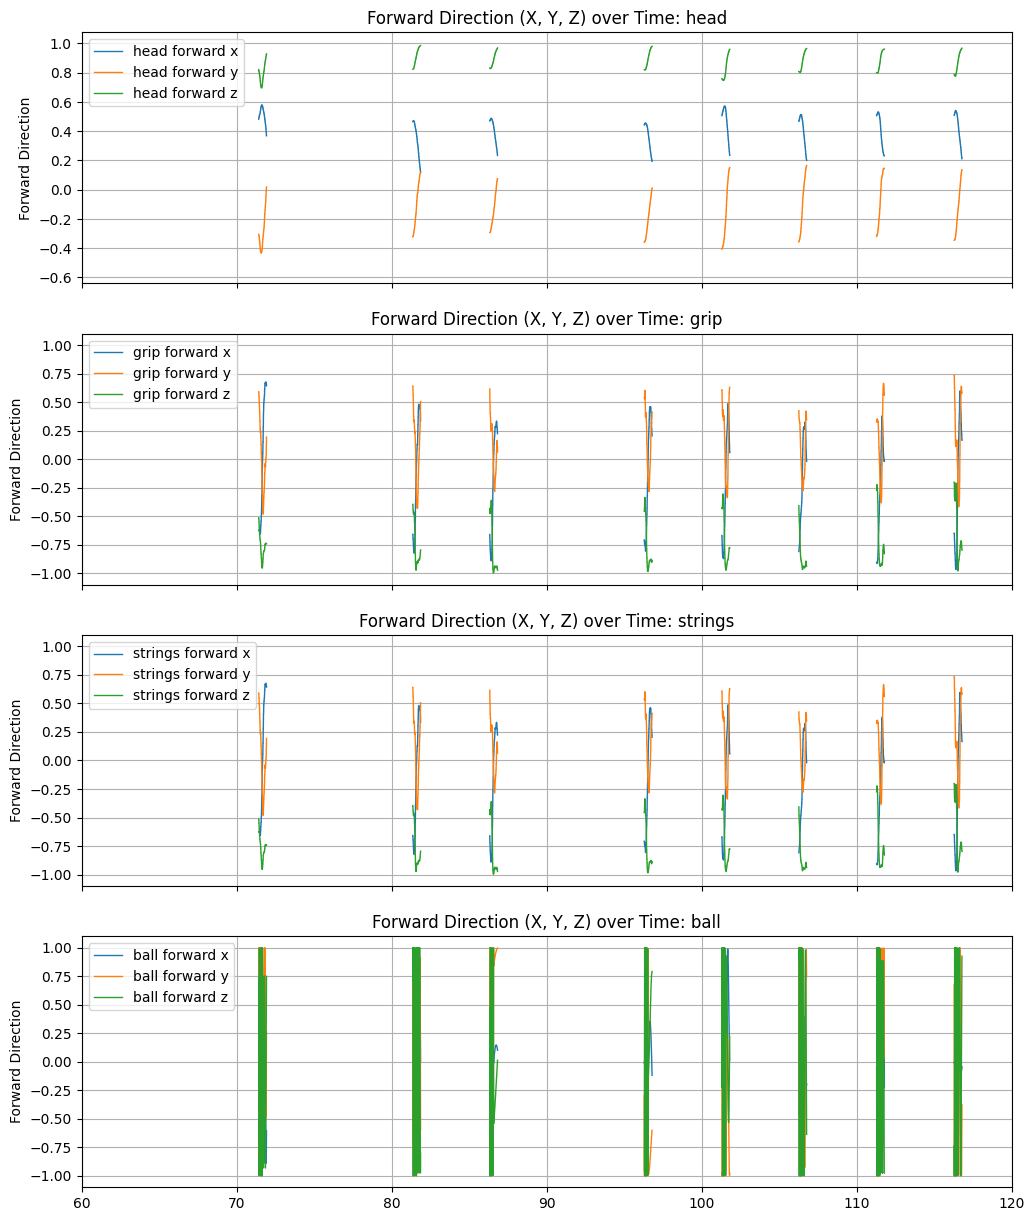

In [335]:
# Forward direction in Unity is typically (0, 0, 1) in local space
def quaternion_to_forward_vector(qx, qy, qz, qw):
    # Convert quaternion to rotation matrix and extract forward vector (z-axis)
    # scipy Rotation expects [x, y, z, w]
    r = R.from_quat([qx, qy, qz, qw])
    # Forward vector in local coordinates is [0, 0, 1]
    forward = r.apply([0, 0, 1])
    return forward


for label in dfs_features_sub:
    df = dfs_features_sub[label]

    # Only compute for rows with non-NaN rotation values
    valid = (
        df[["rotation.x", "rotation.y", "rotation.z", "rotation.w"]]
        .notnull()
        .all(axis=1)
    )
    forward_vectors = np.full((len(df), 3), np.nan)
    if valid.any():
        quats = df.loc[
            valid, ["rotation.x", "rotation.y", "rotation.z", "rotation.w"]
        ].values

        # Compute forward vectors for all valid quaternions
        forward_vectors[valid] = R.from_quat(quats).apply([0, 0, 1])

    # Store as new columns in the dataframe
    df["forward.x"] = forward_vectors[:, 0]
    df["forward.y"] = forward_vectors[:, 1]
    df["forward.z"] = forward_vectors[:, 2]
    dfs_features_sub[label] = df

# Plot the forward direction vectors for each feature
fig, axs = plt.subplots(feature_count, 1, figsize=(12, 15), sharex=True)
for i, label in enumerate(dfs_features_sub):
    df = dfs_features_sub[label]
    axs[i].plot(df["time"], df["forward.x"], label=f"{label} forward x", linewidth=1)
    axs[i].plot(df["time"], df["forward.y"], label=f"{label} forward y", linewidth=1)
    axs[i].plot(df["time"], df["forward.z"], label=f"{label} forward z", linewidth=1)
    axs[i].set_ylabel("Forward Direction")
    axs[i].set_title(f"Forward Direction (X, Y, Z) over Time: {label}")
    axs[i].legend()
    axs[i].grid()
    axs[i].set_xlim([time2exclude, time2exclude + 60])

### normalization: z-scoring

In [336]:
# Normalize each feature in dfs_features_sub using global mean and std across x, y, z coordinates
# for label in dfs_features_sub:
#     df = dfs_features_sub[label]

#     # Stack all position columns to compute global mean and std (ignoring NaNs)
#     position_coordinates = df[["position.x", "position.y", "position.z"]].values
#     global_mean = np.nanmean(position_coordinates)
#     global_std = np.nanstd(position_coordinates)

#     # Normalize each coordinate
#     for coord in ["position.x", "position.y", "position.z"]:
#         df[coord] = (df[coord] - global_mean) / global_std

#     # Stack all forward direction columns to compute global mean and std (ignoring NaNs)
#     forward_coordinates = df[["forward.x", "forward.y", "forward.z"]].values
#     forward_mean = np.nanmean(forward_coordinates)
#     forward_std = np.nanstd(forward_coordinates)

#     # Normalize each forward coordinate
#     for coord in ["forward.x", "forward.y", "forward.z"]:
#         df[coord] = (df[coord] - forward_mean) / forward_std

#     dfs_features_sub[label] = df

### normalization: speed-based

In [337]:
# Normalize each feature in dfs_features_sub using global mean and std across x, y, z coordinates
for label in dfs_features_sub:
    df = dfs_features_sub[label]

    # Stack all position columns to compute global mean and std (ignoring NaNs)
    positions = df[["position.x", "position.y", "position.z"]].values

    # Compute global mean position (ignoring NaNs)
    global_mean = np.nanmean(positions, axis=0)

    # Compute global average speed (Euclidean norm of velocity)
    # First, compute velocity by finite differences
    dt = np.diff(df["time"].values)

    # Compute velocity for each coordinate (shape: [n-1, 3])
    velocities = np.diff(positions, axis=0) / dt[:, None]

    # Compute speed (Euclidean norm), ignoring NaNs
    speeds = np.linalg.norm(velocities, axis=1)
    global_avg_speed = np.nanmean(speeds, axis=0)

    # Normalize each coordinate: subtract mean, divide by global average speed
    for idx, coord in enumerate(["position.x", "position.y", "position.z"]):
        df[coord] = (df[coord] - global_mean[idx]) / global_avg_speed

    dfs_features_sub[label] = df

[head] Variance explained by PC1: 92.91%
[head] Variance explained by PC2: 5.97%
[head] Total variance explained by first 2 PCs: 98.88%


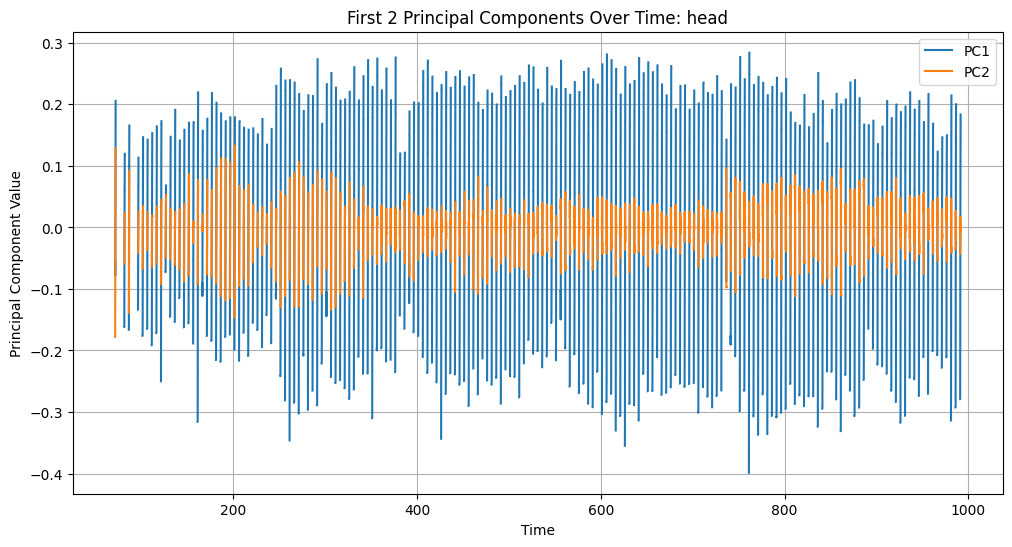

[grip] Variance explained by PC1: 71.69%
[grip] Variance explained by PC2: 27.16%
[grip] Total variance explained by first 2 PCs: 98.85%


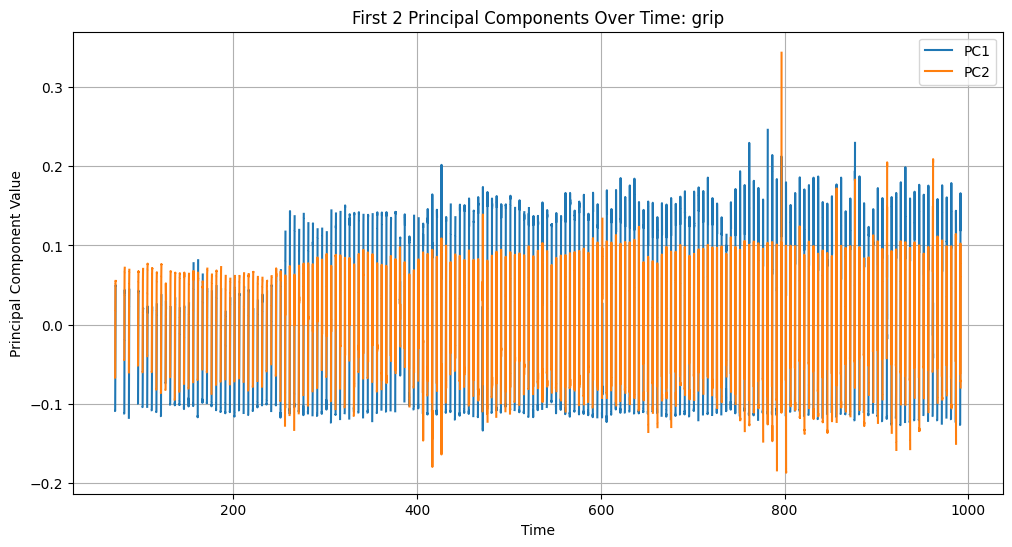

[strings] Variance explained by PC1: 62.48%
[strings] Variance explained by PC2: 34.23%
[strings] Total variance explained by first 2 PCs: 96.71%


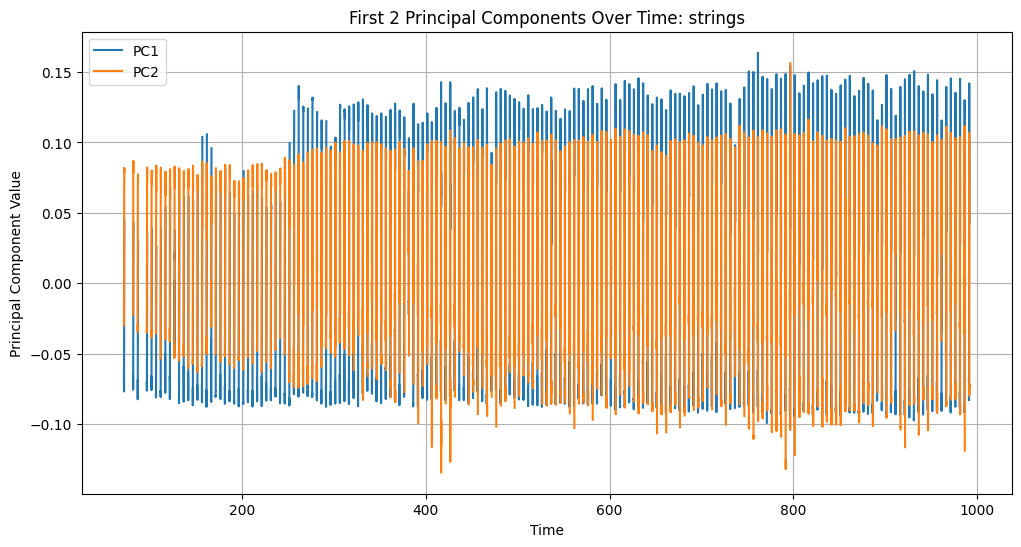

[ball] Variance explained by PC1: 90.71%
[ball] Variance explained by PC2: 6.12%
[ball] Total variance explained by first 2 PCs: 96.84%


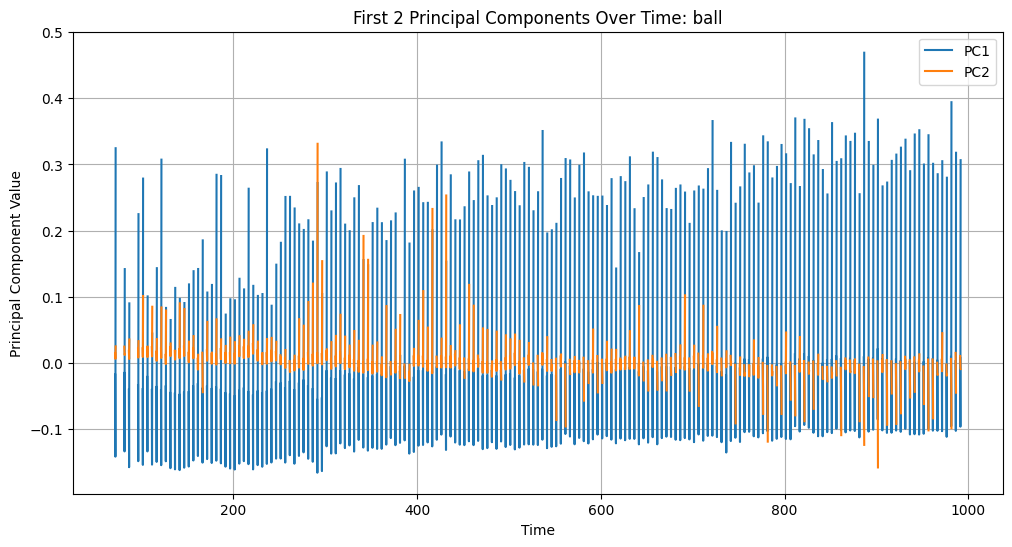

In [338]:
# Perform PCA for both features in features2compare_labels
for label in features2compare_labels:
    df_feat = dfs_features_sub[label]

    # Use only position and forward columns if they exist in the DataFrame
    pca_columns = [
        col
        for col in [
            "position.x",
            "position.y",
            "position.z",
            # "forward.x",
            # "forward.y",
            # "forward.z",
        ]
        if col in df_feat.columns
    ]
    pca_design_matrix = df_feat[pca_columns].values

    # Perform PCA on the position data
    pca = PCA(n_components=3)

    # Remove rows where any position coordinate is NaN before fitting PCA
    valid_mask = ~np.isnan(pca_design_matrix).any(axis=1)
    pca.fit(pca_design_matrix[valid_mask])

    # Report variance explained by the first two PCs
    explained_var = pca.explained_variance_ratio_
    print(f"[{label}] Variance explained by PC1: {explained_var[0]:.2%}")
    print(f"[{label}] Variance explained by PC2: {explained_var[1]:.2%}")
    print(
        f"[{label}] Total variance explained by first 2 PCs: {explained_var[:2].sum():.2%}"
    )

    # Project the positions onto the first two principal components
    pc_scores = pca.transform(pca_design_matrix[valid_mask])
    df_feat["PC1"] = np.nan * np.ones(len(df_feat))
    df_feat["PC2"] = np.nan * np.ones(len(df_feat))
    df_feat["PC3"] = np.nan * np.ones(len(df_feat))

    # Fill the PC1 and PC2 columns only for valid rows
    df_feat.loc[valid_mask, "PC1"] = pc_scores[:, 0]
    df_feat.loc[valid_mask, "PC2"] = pc_scores[:, 1]
    df_feat.loc[valid_mask, "PC3"] = pc_scores[:, 2]
    dfs_features[label] = df_feat  # Update with new columns

    plt.figure(figsize=(12, 6))
    plt.plot(df_feat["time"], df_feat["PC1"], label="PC1")
    plt.plot(df_feat["time"], df_feat["PC2"], label="PC2")
    plt.xlabel("Time")
    plt.ylabel("Principal Component Value")
    plt.title(f"First 2 Principal Components Over Time: {label}")
    plt.legend()
    plt.grid()
    plt.show()

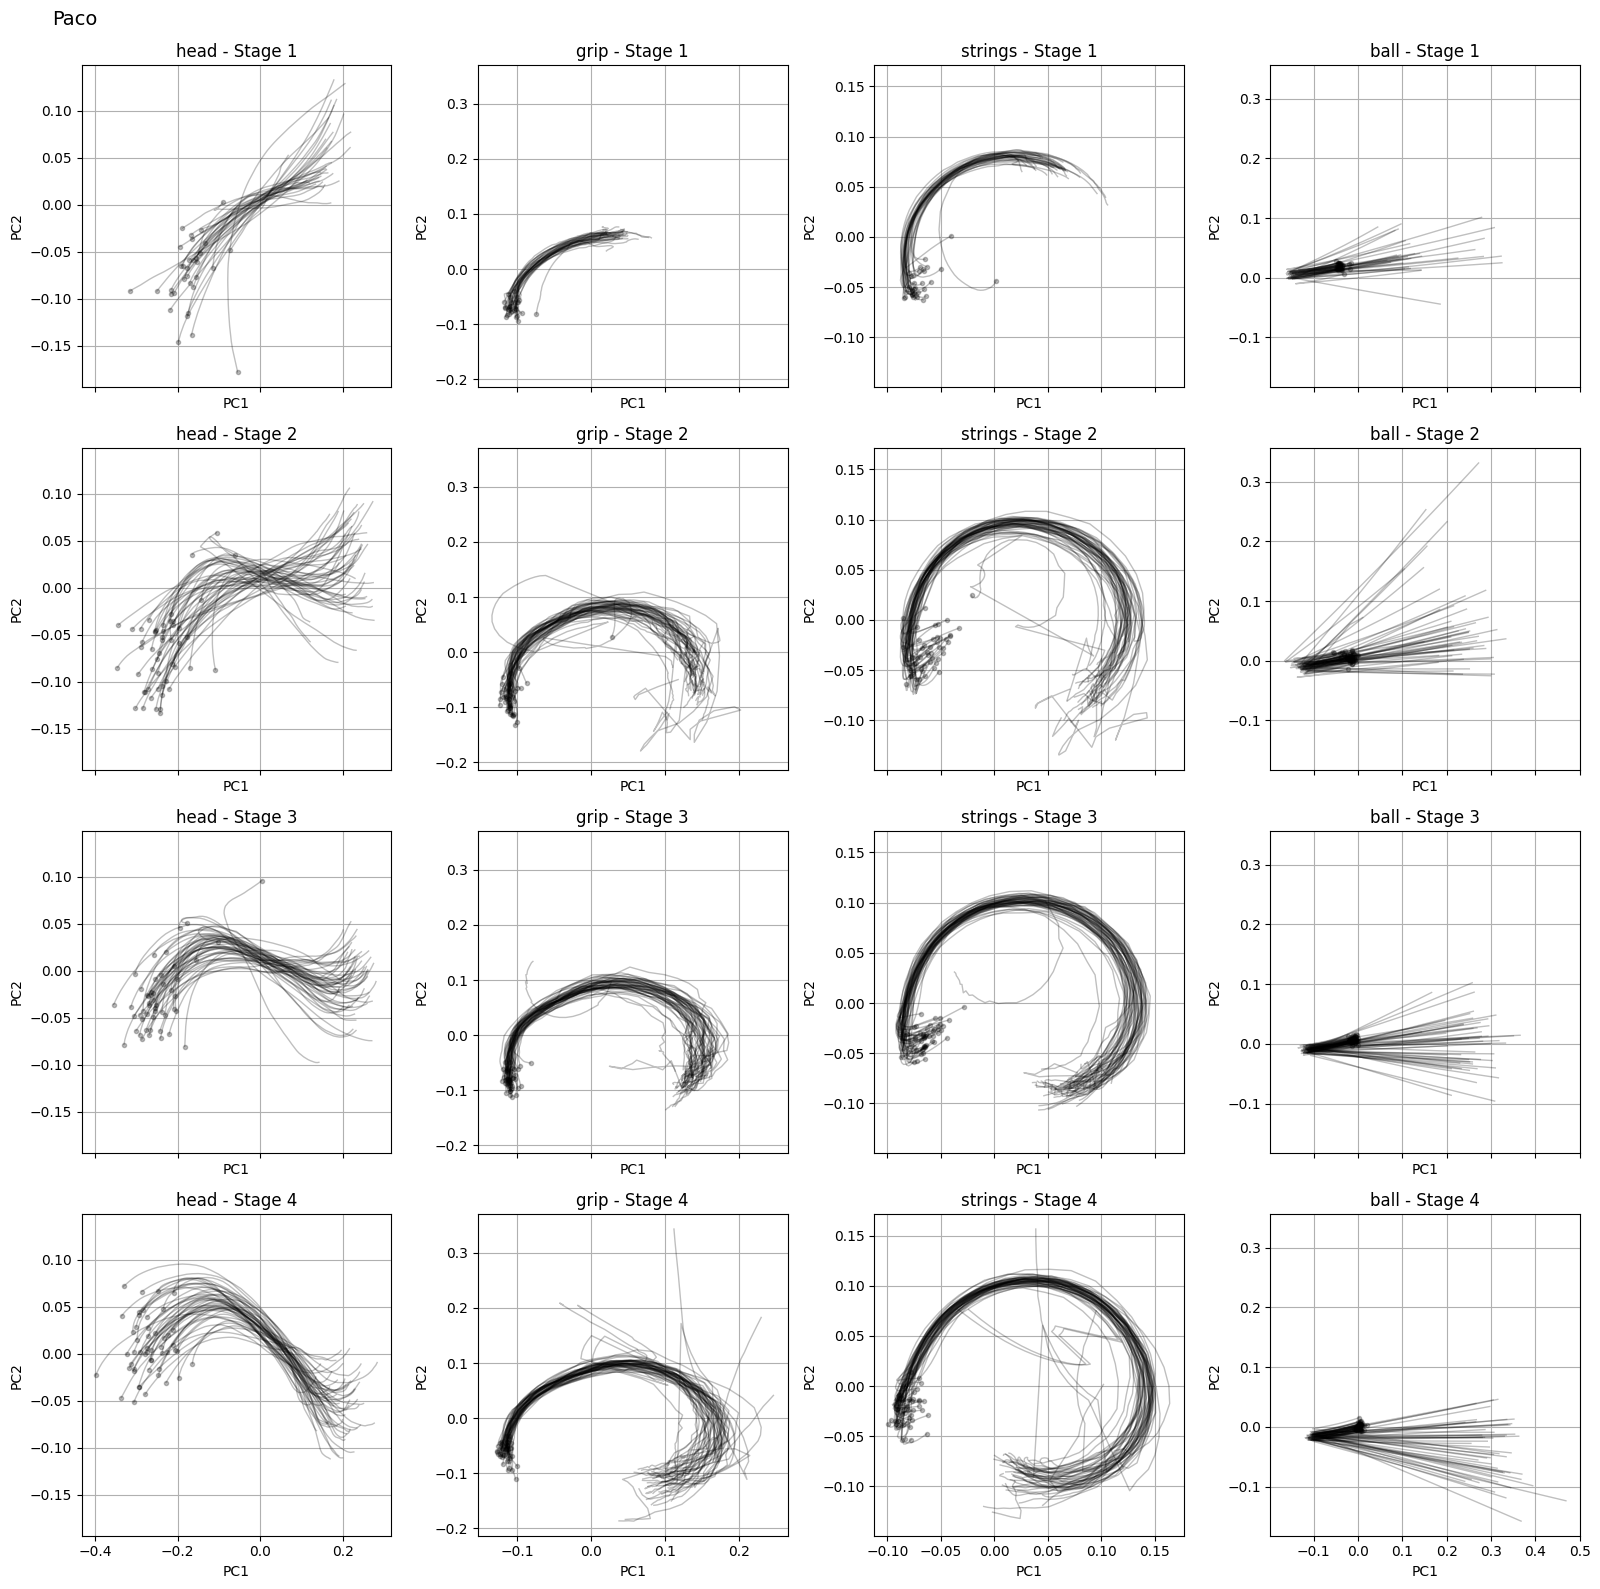

In [339]:
n_stages = 4
fig, axs = plt.subplots(
    n_stages, feature_count, figsize=(16, 4 * n_stages), sharex="col", sharey="col"
)
fig.suptitle(f"{subject2plot}", fontsize=14, x=0.05, y=0.99)

for stage in range(1, n_stages + 1):
    for i, label in enumerate(dfs_features):
        df_feat = dfs_features[label]

        # Filter by stage
        df_stage = df_feat[df_feat["stage"] == stage]
        alignment_times = df_stage[df_stage["event"] == alignment]["time"].values

        trajectories_aligned = []
        for t_align in alignment_times:
            traj = df_stage[
                (df_stage["time"] >= t_align - half_window_duration)
                & (df_stage["time"] <= t_align + half_window_duration)
            ][["PC1", "PC2"]].to_numpy()
            trajectories_aligned.append(traj)

        for traj in trajectories_aligned:
            if traj.shape[0] > 0:
                axs[stage - 1, i].plot(
                    traj[:, 0], traj[:, 1], color="black", alpha=0.25, linewidth=1
                )
                axs[stage - 1, i].plot(
                    traj[0, 0],
                    traj[0, 1],
                    color="black",
                    alpha=0.25,
                    marker="o",
                    markersize=3,
                )

        axs[stage - 1, i].set_title(f"{label} - Stage {stage}")
        axs[stage - 1, i].set_xlabel("PC1")
        axs[stage - 1, i].set_ylabel("PC2")
        axs[stage - 1, i].grid()

plt.tight_layout()
plt.show()

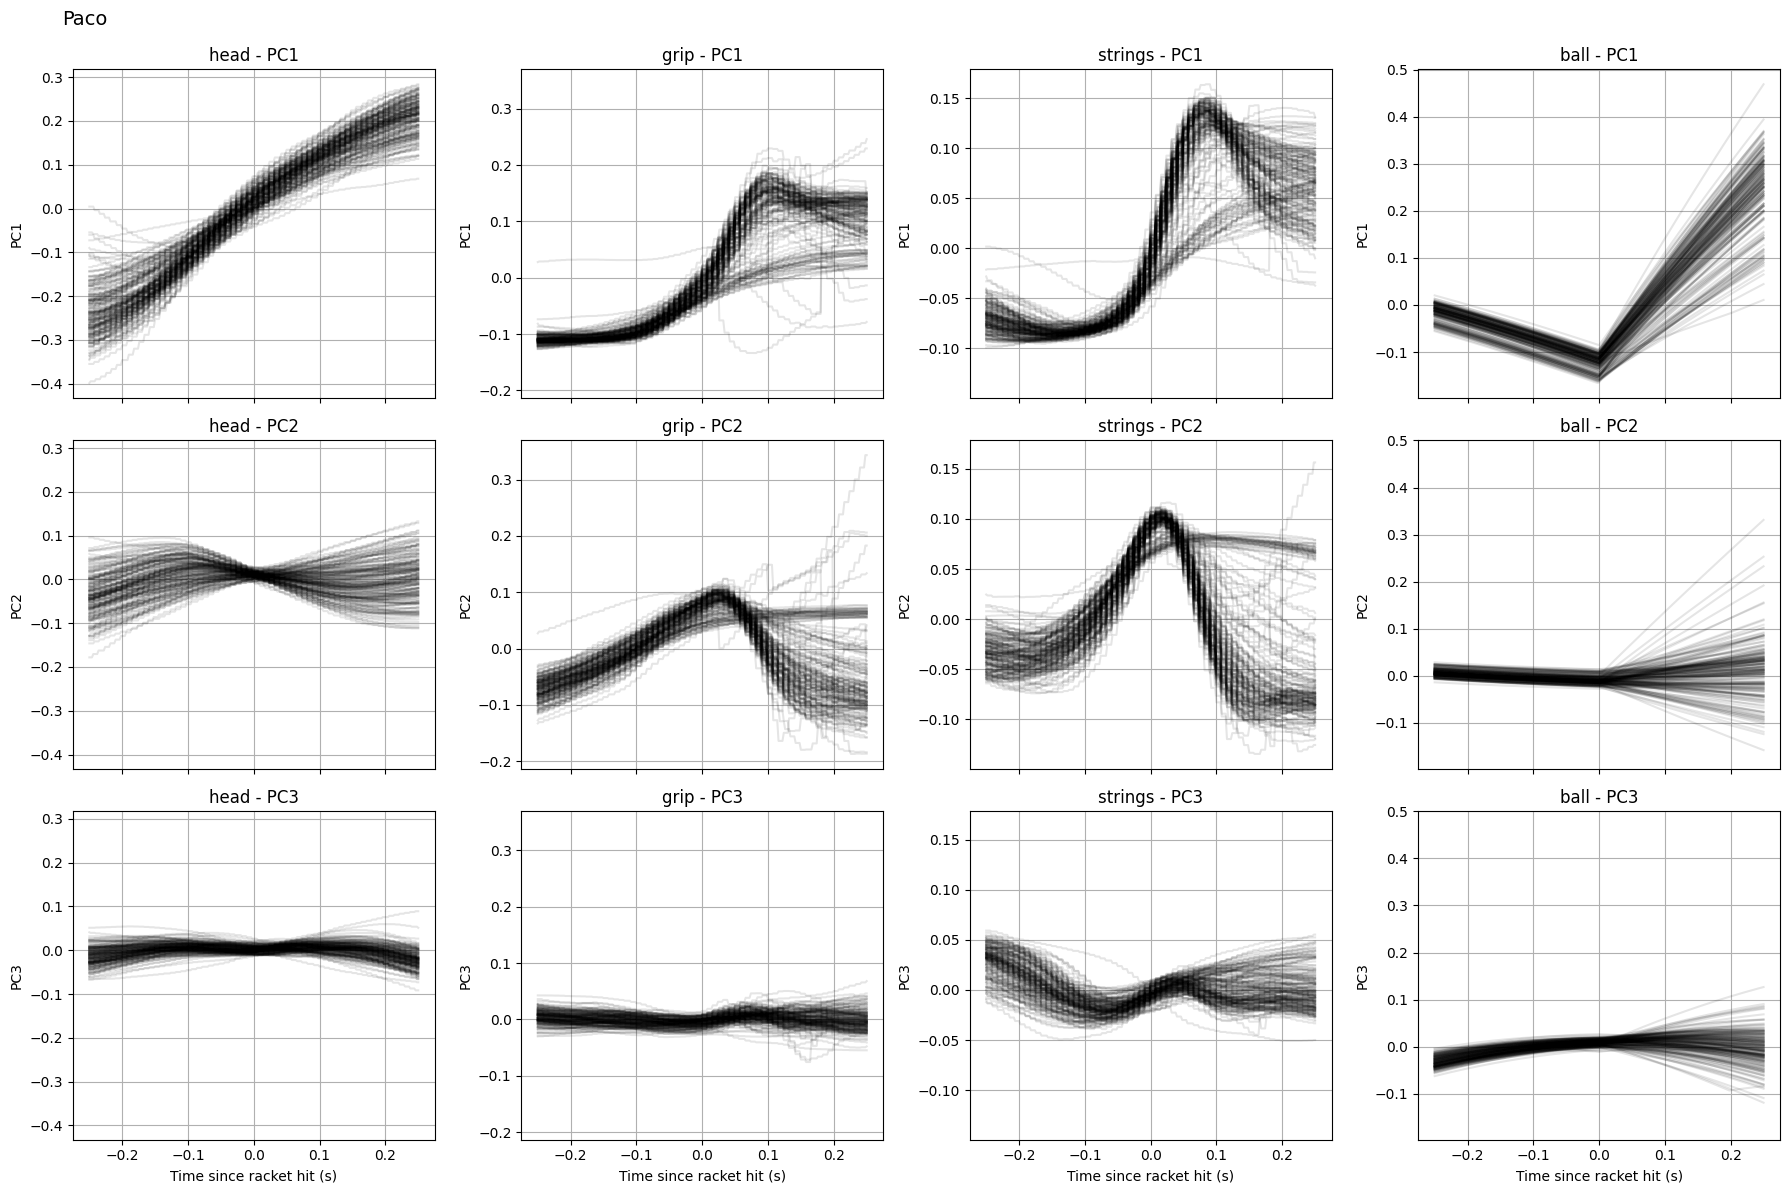

In [340]:
fig, axs = plt.subplots(3, feature_count, figsize=(18, 12), sharex=True, sharey="col")
fig.suptitle(f"{subject2plot}", fontsize=14, x=0.05, y=0.99)

for i, label in enumerate(features2compare_labels):
    df_feat = dfs_features[label]
    alignment_times = df_feat[df_feat["event"] == alignment]["time"].values

    # Collect aligned trajectories for PC1, PC2, and PC3
    aligned_pc1 = []
    aligned_pc2 = []
    aligned_pc3 = []
    for t_align in alignment_times:
        traj = df_feat[
            (df_feat["time"] >= t_align - half_window_duration)
            & (df_feat["time"] <= t_align + half_window_duration)
        ][["PC1", "PC2", "PC3"]].to_numpy()

        # Only keep trajectories with valid data
        if traj.shape[0] > 0:
            aligned_pc1.append(traj[:, 0])
            aligned_pc2.append(traj[:, 1])
            aligned_pc3.append(traj[:, 2])

    # Plot PC1
    for traj_pc1 in aligned_pc1:
        try:
            axs[0, i].plot(window_time, traj_pc1, color="black", alpha=0.1)
        except Exception as e:
            print(f"Error plotting PC1 for {label}: {e}")
    axs[0, i].set_title(f"{label} - PC1")
    axs[0, i].set_ylabel("PC1")
    axs[0, i].grid()

    # Plot PC2
    for traj_pc2 in aligned_pc2:
        try:
            axs[1, i].plot(window_time, traj_pc2, color="black", alpha=0.1)
        except Exception as e:
            print(f"Error plotting PC2 for {label}: {e}")
    axs[1, i].set_title(f"{label} - PC2")
    axs[1, i].set_ylabel("PC2")
    axs[1, i].grid()

    # Plot PC3
    for traj_pc3 in aligned_pc3:
        try:
            axs[2, i].plot(window_time, traj_pc3, color="black", alpha=0.1)
        except Exception as e:
            print(f"Error plotting PC3 for {label}: {e}")
    axs[2, i].set_title(f"{label} - PC3")
    axs[2, i].set_ylabel("PC3")
    axs[2, i].grid()

for i in range(feature_count):
    axs[2, i].set_xlabel("Time since racket hit (s)")
plt.tight_layout()
plt.show()

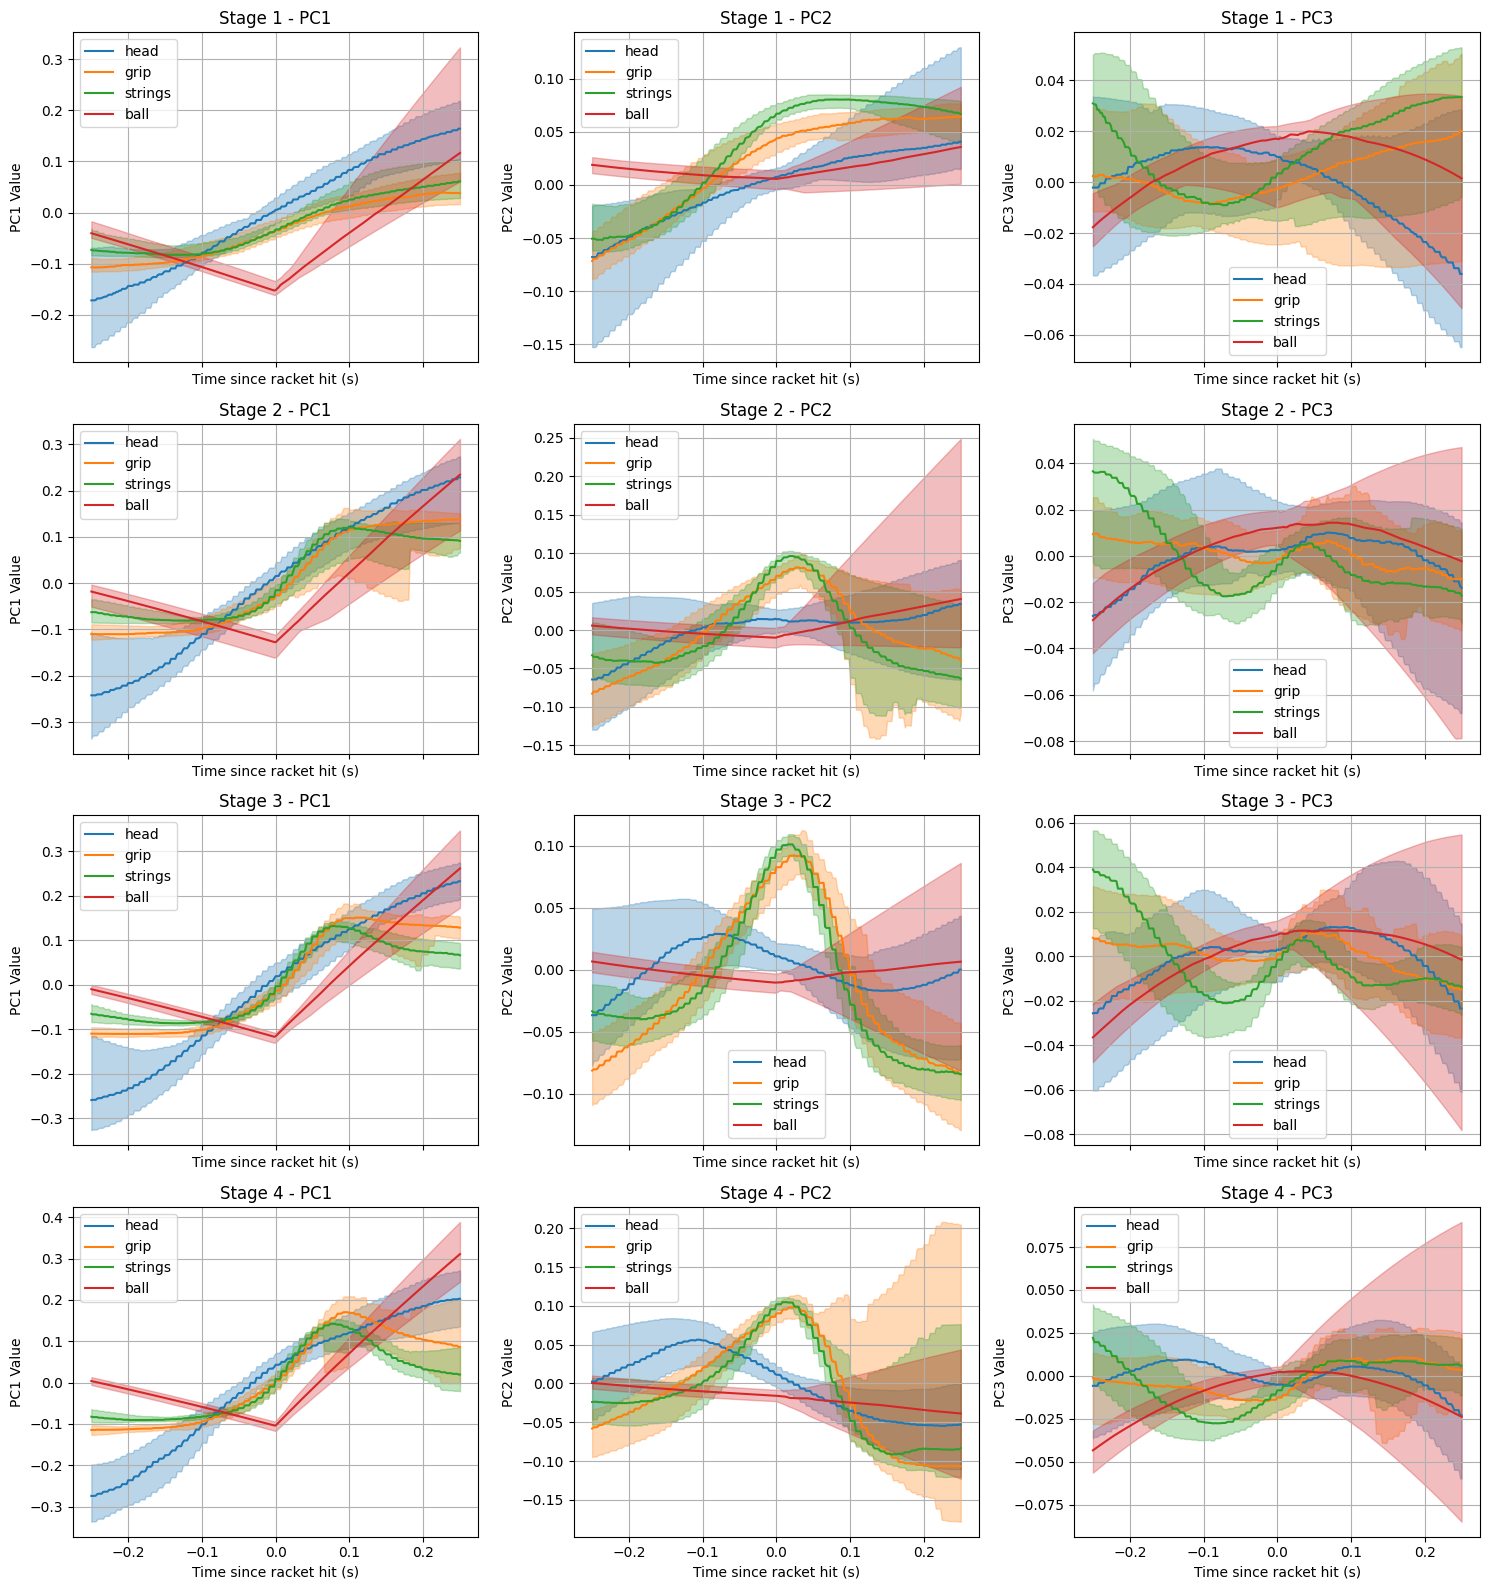

In [341]:
lower_percentile = 2.5
upper_percentile = 97.5

fig, axs = plt.subplots(
    n_stages, 3, figsize=(15, 4 * n_stages), sharex="col", sharey=False
)

for stage in range(1, n_stages + 1):
    for f_idx, label in enumerate(features2compare_labels):
        df_feat = dfs_features[label]

        # Filter by stage
        df_stage = df_feat[df_feat["stage"] == stage]
        alignment_times = df_stage[df_stage["event"] == alignment]["time"].values

        aligned_pc1 = []
        aligned_pc2 = []
        aligned_pc3 = []
        for t_align in alignment_times:
            traj = df_stage[
                (df_stage["time"] >= t_align - half_window_duration)
                & (df_stage["time"] <= t_align + half_window_duration)
            ][["PC1", "PC2", "PC3"]].to_numpy()
            if traj.shape[0] == window_size:
                aligned_pc1.append(traj[:, 0])
                aligned_pc2.append(traj[:, 1])
                aligned_pc3.append(traj[:, 2])

        aligned_pc1 = np.array(aligned_pc1)
        aligned_pc2 = np.array(aligned_pc2)
        aligned_pc3 = np.array(aligned_pc3)

        # PC1
        if aligned_pc1.shape[0] > 0:
            q1_pc1 = np.percentile(aligned_pc1, lower_percentile, axis=0)
            q3_pc1 = np.percentile(aligned_pc1, upper_percentile, axis=0)
            axs[stage - 1, 0].fill_between(
                window_time, q1_pc1, q3_pc1, alpha=0.3, color=feature_colors[f_idx]
            )
            axs[stage - 1, 0].plot(
                window_time,
                np.median(aligned_pc1, axis=0),
                color=feature_colors[f_idx],
                label=f"{label}",
            )

        # PC2
        if aligned_pc2.shape[0] > 0:
            q1_pc2 = np.percentile(aligned_pc2, lower_percentile, axis=0)
            q3_pc2 = np.percentile(aligned_pc2, upper_percentile, axis=0)
            axs[stage - 1, 1].fill_between(
                window_time, q1_pc2, q3_pc2, alpha=0.3, color=feature_colors[f_idx]
            )
            axs[stage - 1, 1].plot(
                window_time,
                np.median(aligned_pc2, axis=0),
                color=feature_colors[f_idx],
                label=f"{label}",
            )

        # PC3
        if aligned_pc3.shape[0] > 0:
            q1_pc3 = np.percentile(aligned_pc3, lower_percentile, axis=0)
            q3_pc3 = np.percentile(aligned_pc3, upper_percentile, axis=0)
            axs[stage - 1, 2].fill_between(
                window_time, q1_pc3, q3_pc3, alpha=0.3, color=feature_colors[f_idx]
            )
            axs[stage - 1, 2].plot(
                window_time,
                np.median(aligned_pc3, axis=0),
                color=feature_colors[f_idx],
                label=f"{label}",
            )

    axs[stage - 1, 0].set_title(f"Stage {stage} - PC1")
    axs[stage - 1, 0].set_xlabel("Time since racket hit (s)")
    axs[stage - 1, 0].set_ylabel("PC1 Value")
    axs[stage - 1, 0].legend()
    axs[stage - 1, 0].grid()

    axs[stage - 1, 1].set_title(f"Stage {stage} - PC2")
    axs[stage - 1, 1].set_xlabel("Time since racket hit (s)")
    axs[stage - 1, 1].set_ylabel("PC2 Value")
    axs[stage - 1, 1].legend()
    axs[stage - 1, 1].grid()

    axs[stage - 1, 2].set_title(f"Stage {stage} - PC3")
    axs[stage - 1, 2].set_xlabel("Time since racket hit (s)")
    axs[stage - 1, 2].set_ylabel("PC3 Value")
    axs[stage - 1, 2].legend()
    axs[stage - 1, 2].grid()

plt.tight_layout()
plt.show()

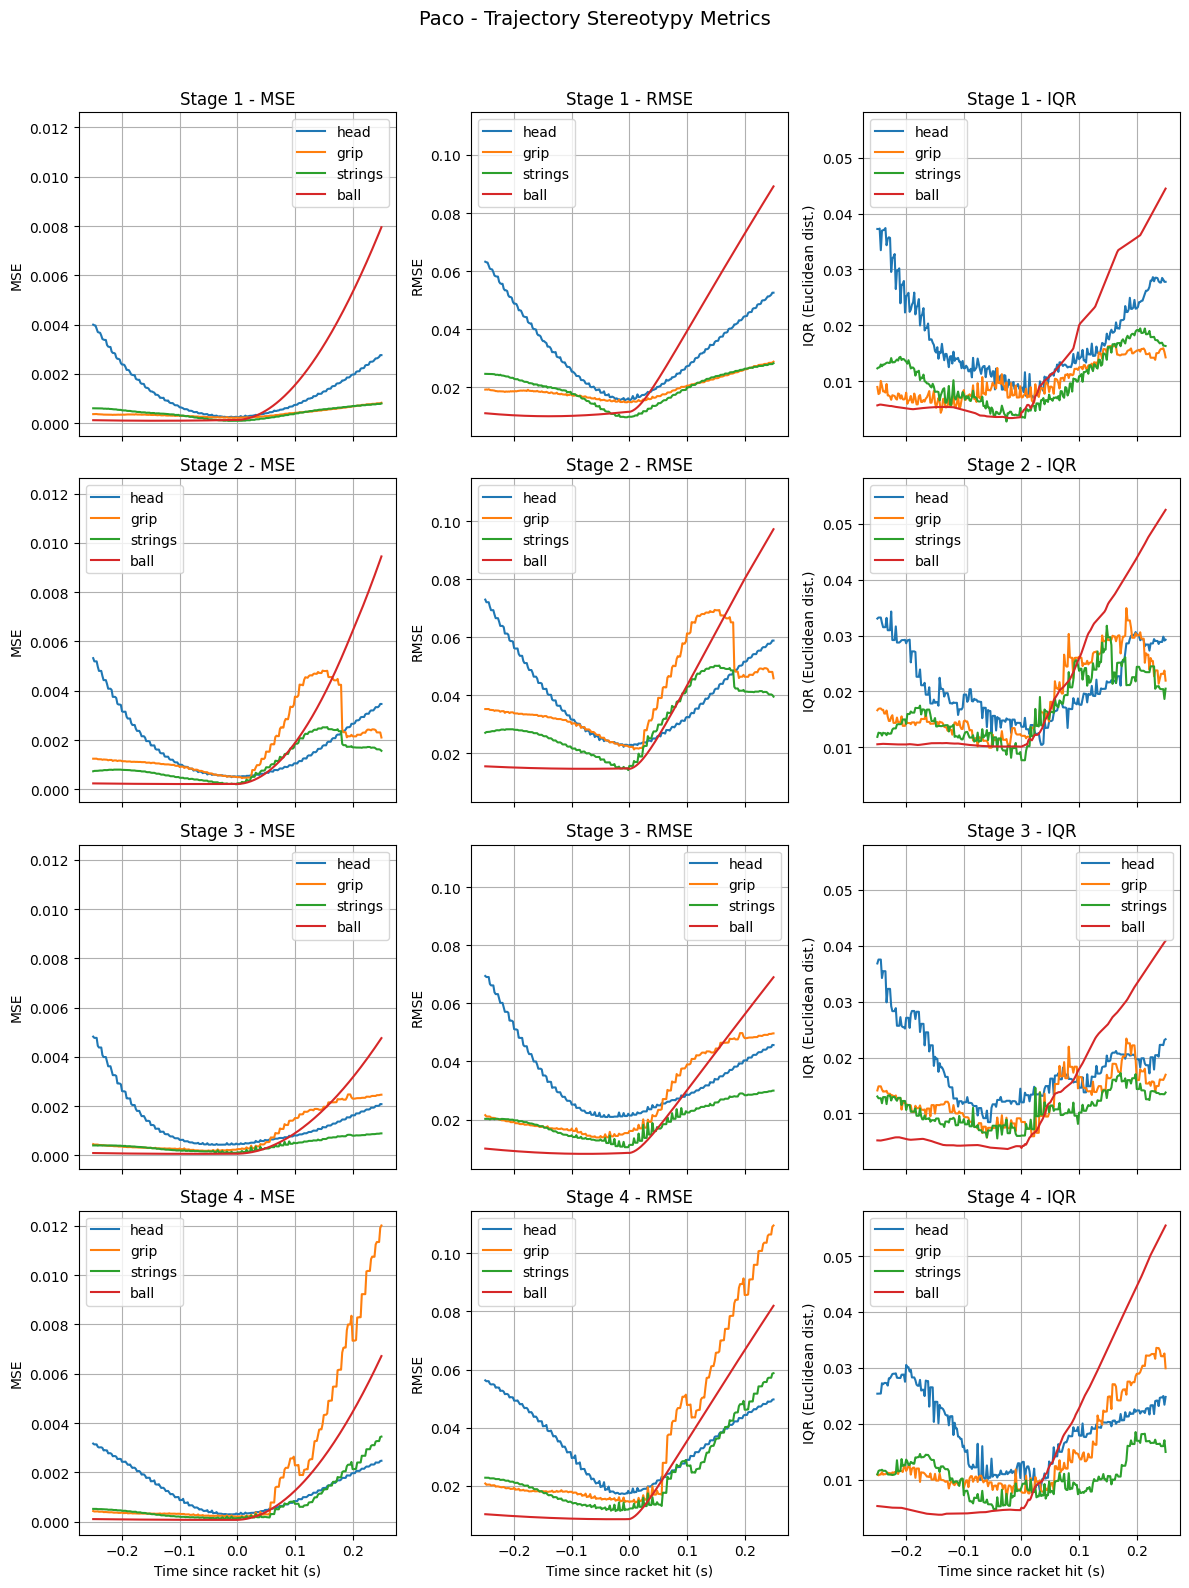

In [342]:
# Plot stereotypy metrics: MSE, RMSE, and IQR (no DTW)
fig, axs = plt.subplots(
    n_stages, 3, figsize=(12, 4 * n_stages), sharex=True, sharey="col"
)
fig.suptitle(
    f"{subject2plot} - Trajectory Stereotypy Metrics", fontsize=14, x=0.5, y=0.99
)

for stage in range(1, n_stages + 1):
    for f_idx, label in enumerate(features2compare_labels):
        df_feat = dfs_features[label]

        # Filter by stage
        df_stage = df_feat[df_feat["stage"] == stage]
        alignment_times = df_stage[df_stage["event"] == alignment]["time"].values

        aligned_trajs = []
        for t_align in alignment_times:
            traj = df_stage[
                (df_stage["time"] >= t_align - half_window_duration)
                & (df_stage["time"] <= t_align + half_window_duration)
            ][["PC1", "PC2", "PC3"]].to_numpy()
            if traj.shape[0] == window_size:
                aligned_trajs.append(traj)

        aligned_trajs = np.array(aligned_trajs)  # shape: (n_trials, window_size, 3)
        if aligned_trajs.shape[0] == 0:
            continue

        # Mean trajectory
        mean_traj = np.mean(aligned_trajs, axis=0)  # (window_size, 3)

        # MSE: mean squared error to the mean trajectory at each time
        mse = np.mean(
            np.sum((aligned_trajs - mean_traj) ** 2, axis=2), axis=0
        )  # (window_size,)

        # RMSE: root mean squared error to the mean trajectory at each time
        rmse = np.sqrt(mse)  # (window_size,)

        # IQR: interquartile range of Euclidean distances to the mean trajectory at each time
        dists = np.linalg.norm(aligned_trajs - mean_traj, axis=2)  # (n_trials, window_size)
        iqr = np.percentile(dists, 75, axis=0) - np.percentile(dists, 25, axis=0)

        axs[stage - 1, 0].plot(
            window_time, mse, color=feature_colors[f_idx], label=label
        )
        axs[stage - 1, 1].plot(
            window_time, rmse, color=feature_colors[f_idx], label=label
        )
        axs[stage - 1, 2].plot(
            window_time, iqr, color=feature_colors[f_idx], label=label
        )

    axs[stage - 1, 0].set_title(f"Stage {stage} - MSE")
    axs[stage - 1, 0].set_ylabel("MSE")
    axs[stage - 1, 0].legend()
    axs[stage - 1, 0].grid()

    axs[stage - 1, 1].set_title(f"Stage {stage} - RMSE")
    axs[stage - 1, 1].set_ylabel("RMSE")
    axs[stage - 1, 1].legend()
    axs[stage - 1, 1].grid()

    axs[stage - 1, 2].set_title(f"Stage {stage} - IQR")
    axs[stage - 1, 2].set_ylabel("IQR (Euclidean dist.)")
    axs[stage - 1, 2].legend()
    axs[stage - 1, 2].grid()

for ax in axs[-1, :]:
    ax.set_xlabel("Time since racket hit (s)")

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


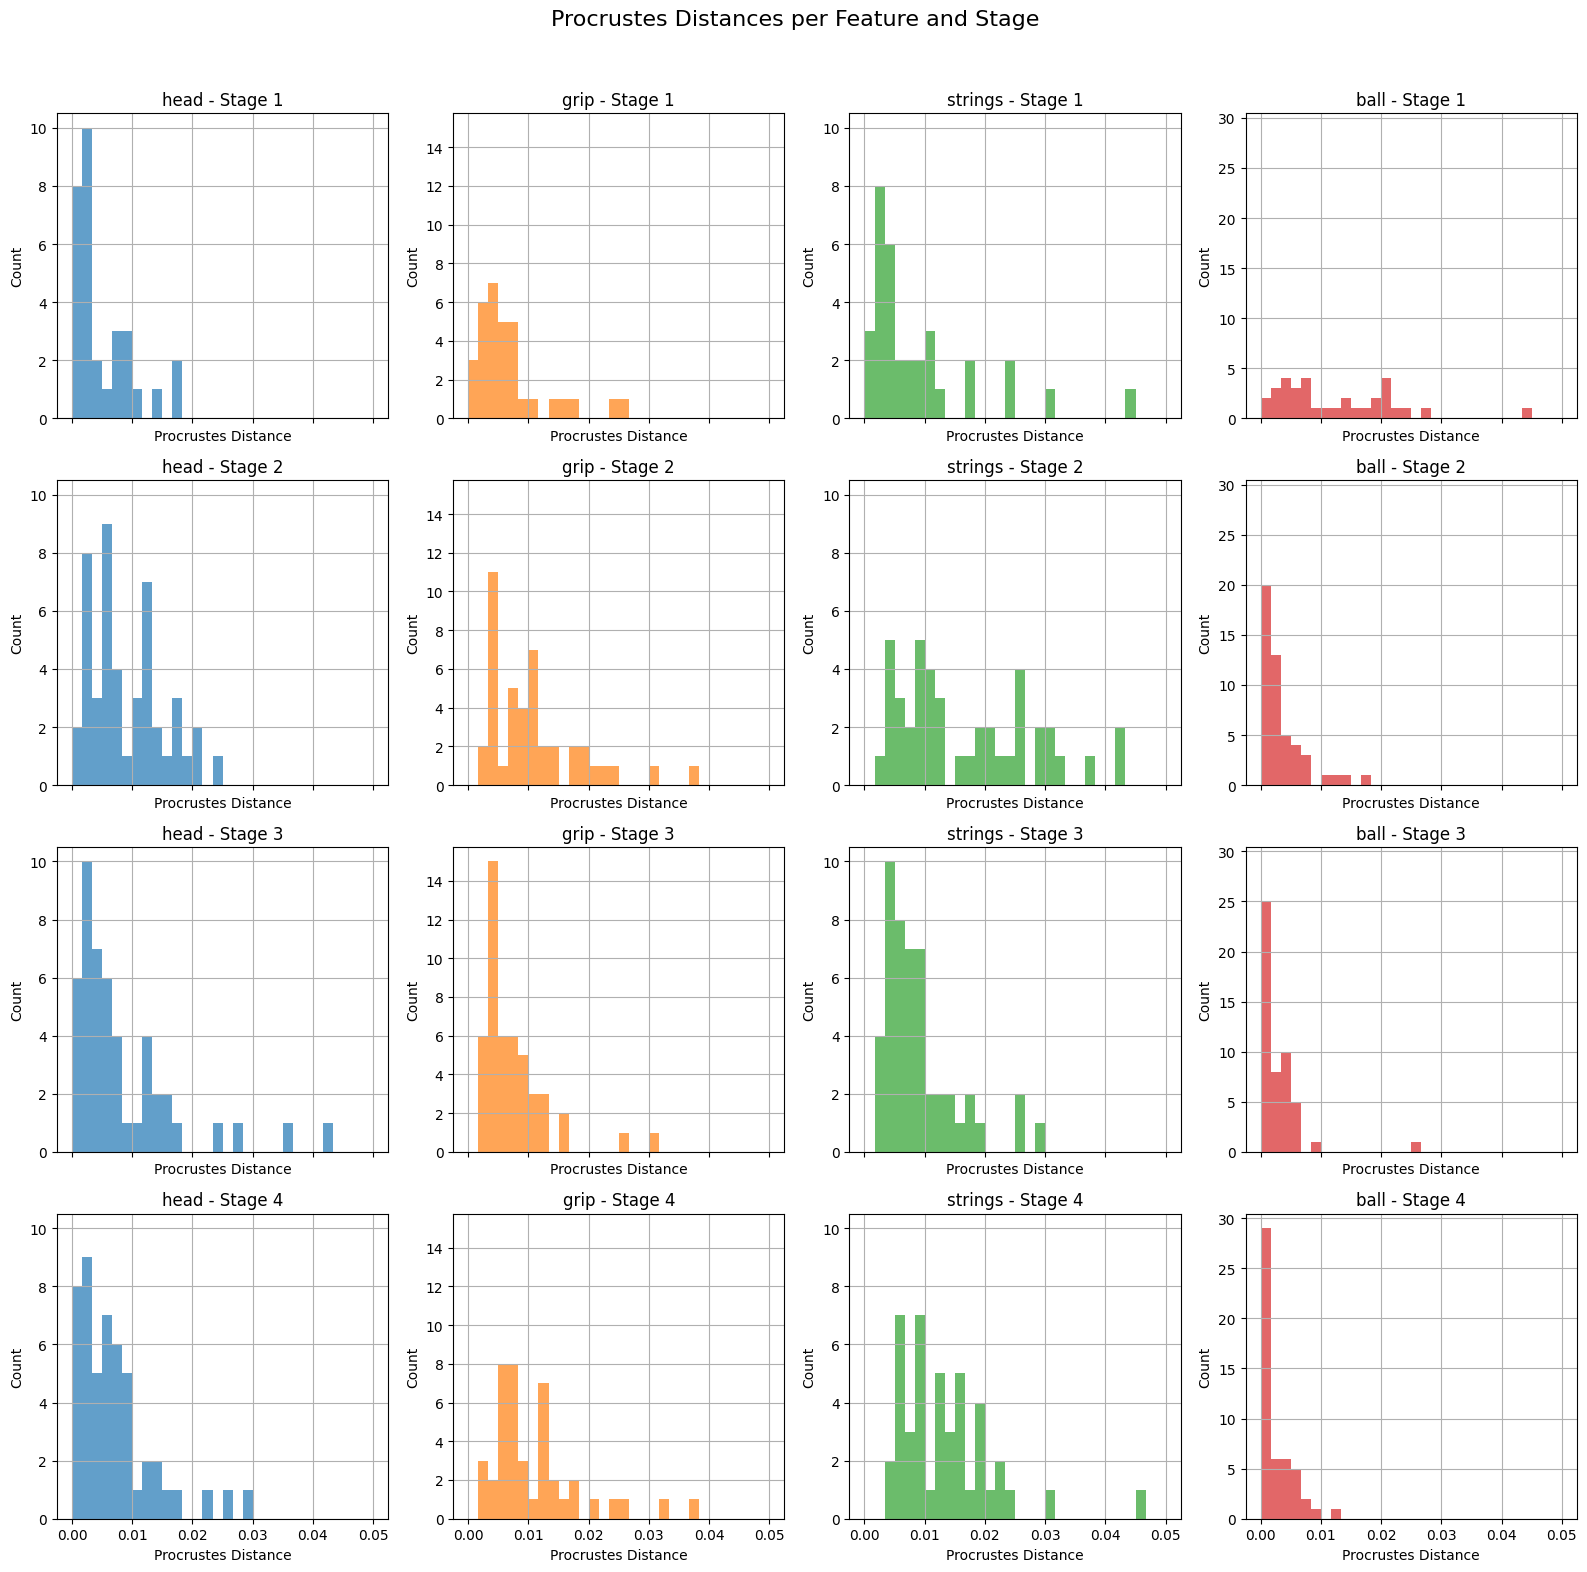

In [343]:
fig, axs = plt.subplots(
    n_stages, feature_count, figsize=(16, 4 * n_stages), sharex=True, sharey="col"
)
fig.suptitle("Procrustes Distances per Feature and Stage", fontsize=16, y=0.98)

num_bins = 30  # Number of bins for histogram
bin_edges = np.linspace(0, 0.05, num_bins + 1)  # Adjust range as needed

for stage in range(1, n_stages + 1):
    for f_idx, label in enumerate(features2compare_labels):
        df_feat = dfs_features[label]
        # Filter by stage
        df_stage = df_feat[df_feat["stage"] == stage]
        alignment_times = df_stage[df_stage["event"] == alignment]["time"].values

        # Collect aligned trajectories (PC1, PC2)
        aligned_trajs = []
        for t_align in alignment_times:
            traj = df_stage[
                (df_stage["time"] >= t_align - half_window_duration)
                & (df_stage["time"] <= t_align + half_window_duration)
            ][["position.x", "position.y", "position.z"]].to_numpy()
            # ][["PC1", "PC2"]].to_numpy()
            if traj.shape[0] == window_size:
                aligned_trajs.append(traj)
        aligned_trajs = np.array(aligned_trajs)  # shape: (n_trials, window_size, 3)

        if aligned_trajs.shape[0] == 0:
            continue

        # Compute mean trajectory for the stage
        mean_traj = np.mean(aligned_trajs, axis=0)

        # Compute Procrustes distance for each trial to the mean trajectory
        procrustes_distances = []
        for traj in aligned_trajs:
            # procrustes returns (mtx1, mtx2, disparity)
            _, _, disparity = procrustes(mean_traj, traj)
            procrustes_distances.append(disparity)
        procrustes_distances = np.array(procrustes_distances)

        axs[stage - 1, f_idx].hist(
            procrustes_distances, bins=bin_edges, color=feature_colors[f_idx], alpha=0.7
        )
        axs[stage - 1, f_idx].set_title(f"{label} - Stage {stage}")
        axs[stage - 1, f_idx].set_xlabel("Procrustes Distance")
        axs[stage - 1, f_idx].set_ylabel("Count")
        axs[stage - 1, f_idx].grid()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

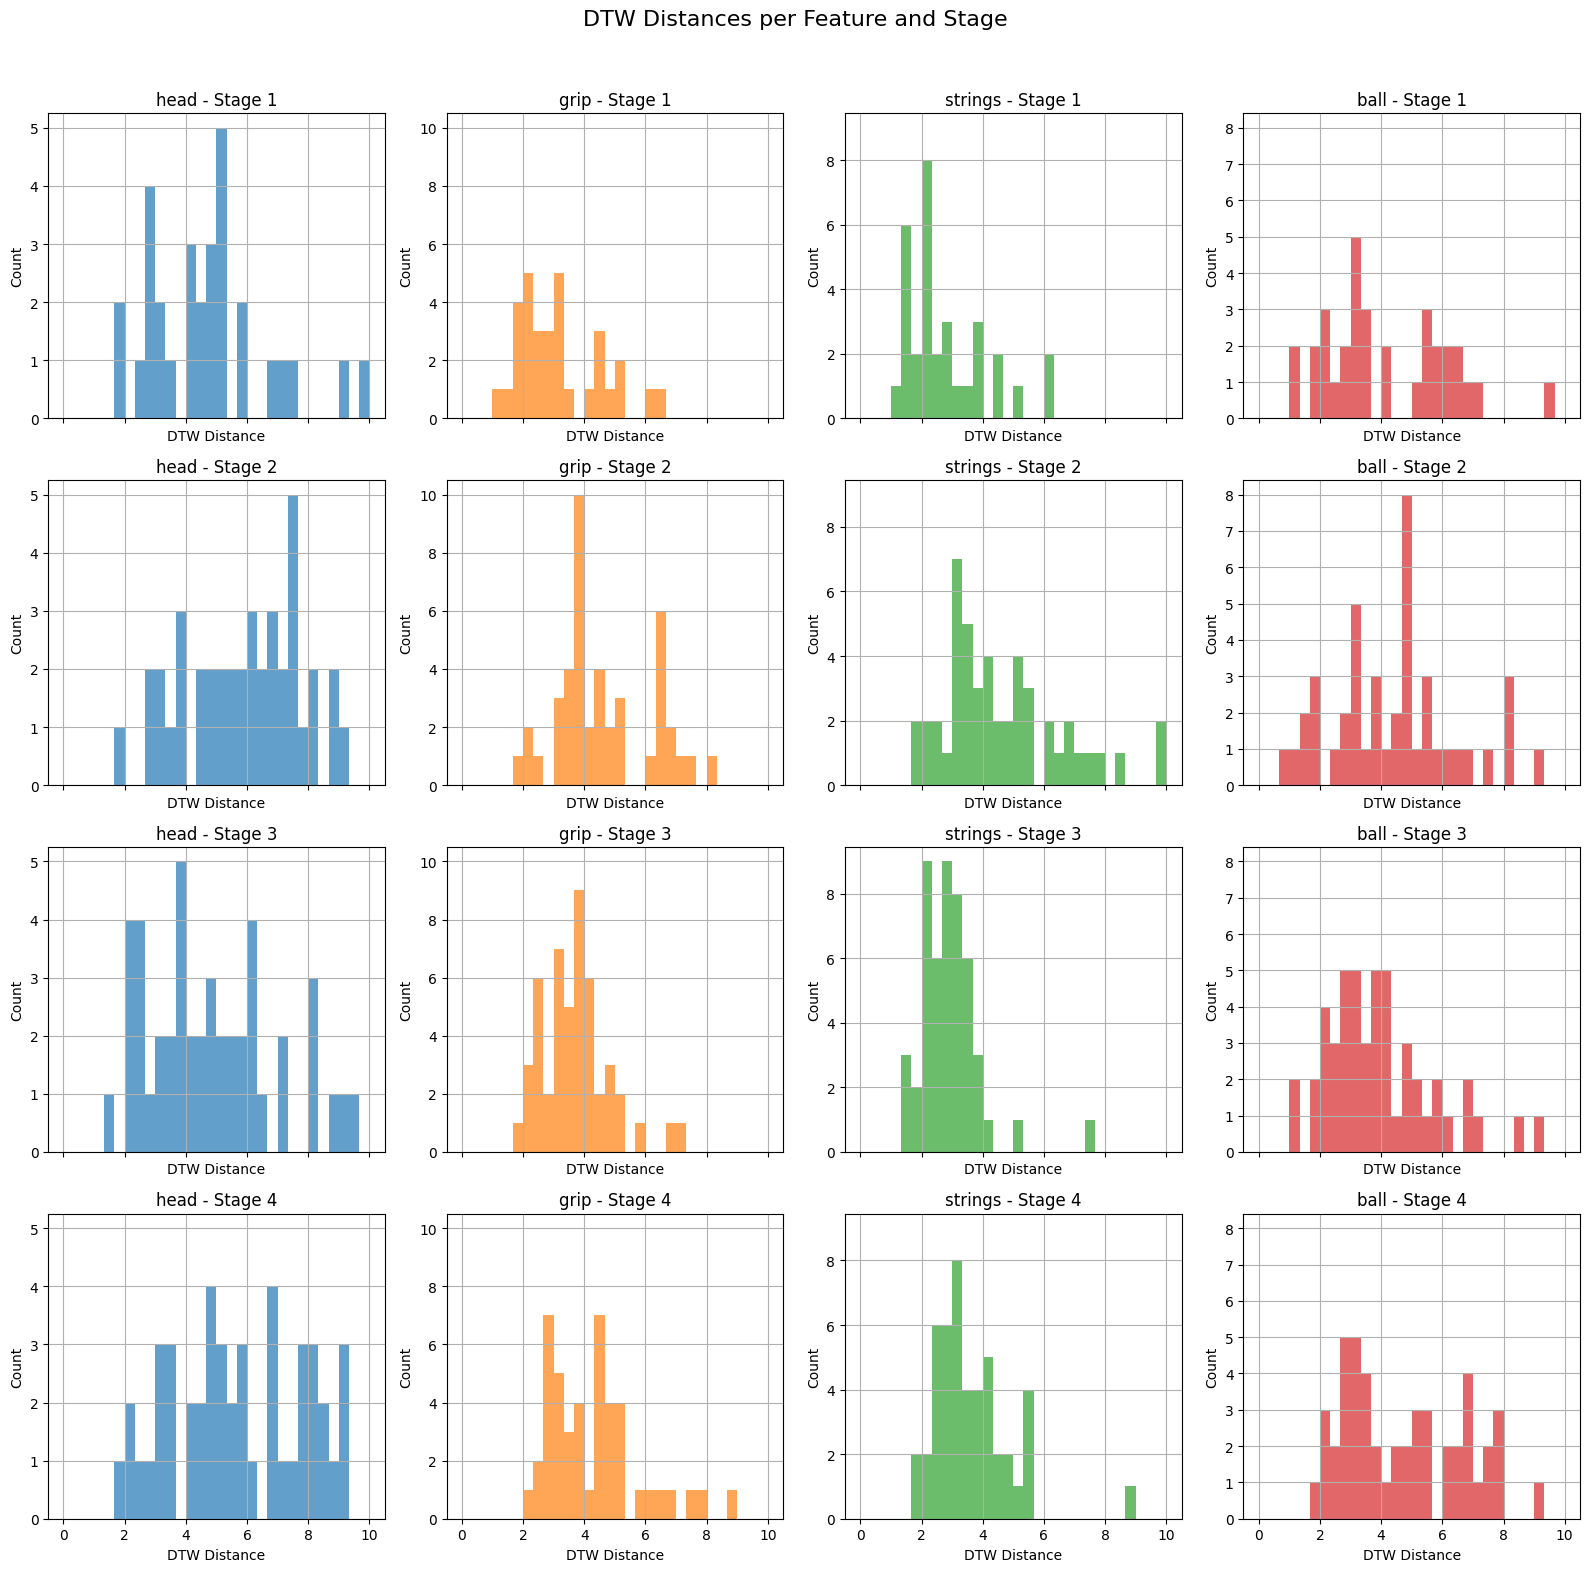

In [344]:
fig, axs = plt.subplots(
    n_stages, feature_count, figsize=(16, 4 * n_stages), sharex=True, sharey="col"
)
fig.suptitle("DTW Distances per Feature and Stage", fontsize=16, y=0.98)

num_bins = 30  # Number of bins for histogram
bin_edges = np.linspace(0, 10, num_bins + 1)  # Adjust range as needed

for stage in range(1, n_stages + 1):
    for f_idx, label in enumerate(features2compare_labels):
        df_feat = dfs_features[label]

        # Filter by stage
        df_stage = df_feat[df_feat["stage"] == stage]
        alignment_times = df_stage[df_stage["event"] == alignment]["time"].values

        # Collect aligned trajectories (PC1, PC2, PC3)
        aligned_trajs = []
        for t_align in alignment_times:
            traj = df_stage[
                (df_stage["time"] >= t_align - half_window_duration)
                & (df_stage["time"] <= t_align + half_window_duration)
            ][["position.x", "position.y", "position.z"]].to_numpy()
            if traj.shape[0] == window_size:
                aligned_trajs.append(traj)
        aligned_trajs = np.array(aligned_trajs)  # shape: (n_trials, window_size, 3)

        if aligned_trajs.shape[0] == 0:
            continue

        # Compute mean trajectory for the stage
        mean_traj = np.mean(aligned_trajs, axis=0)

        # Compute DTW distance for each trial to the mean trajectory
        dtw_distances = []
        for traj in aligned_trajs:
            distance, _ = fastdtw(traj, mean_traj, dist=euclidean)
            dtw_distances.append(distance)
        dtw_distances = np.array(dtw_distances)

        axs[stage - 1, f_idx].hist(
            dtw_distances, bins=bin_edges, color=feature_colors[f_idx], alpha=0.7
        )
        axs[stage - 1, f_idx].set_title(f"{label} - Stage {stage}")
        axs[stage - 1, f_idx].set_xlabel("DTW Distance")
        axs[stage - 1, f_idx].set_ylabel("Count")
        axs[stage - 1, f_idx].grid()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

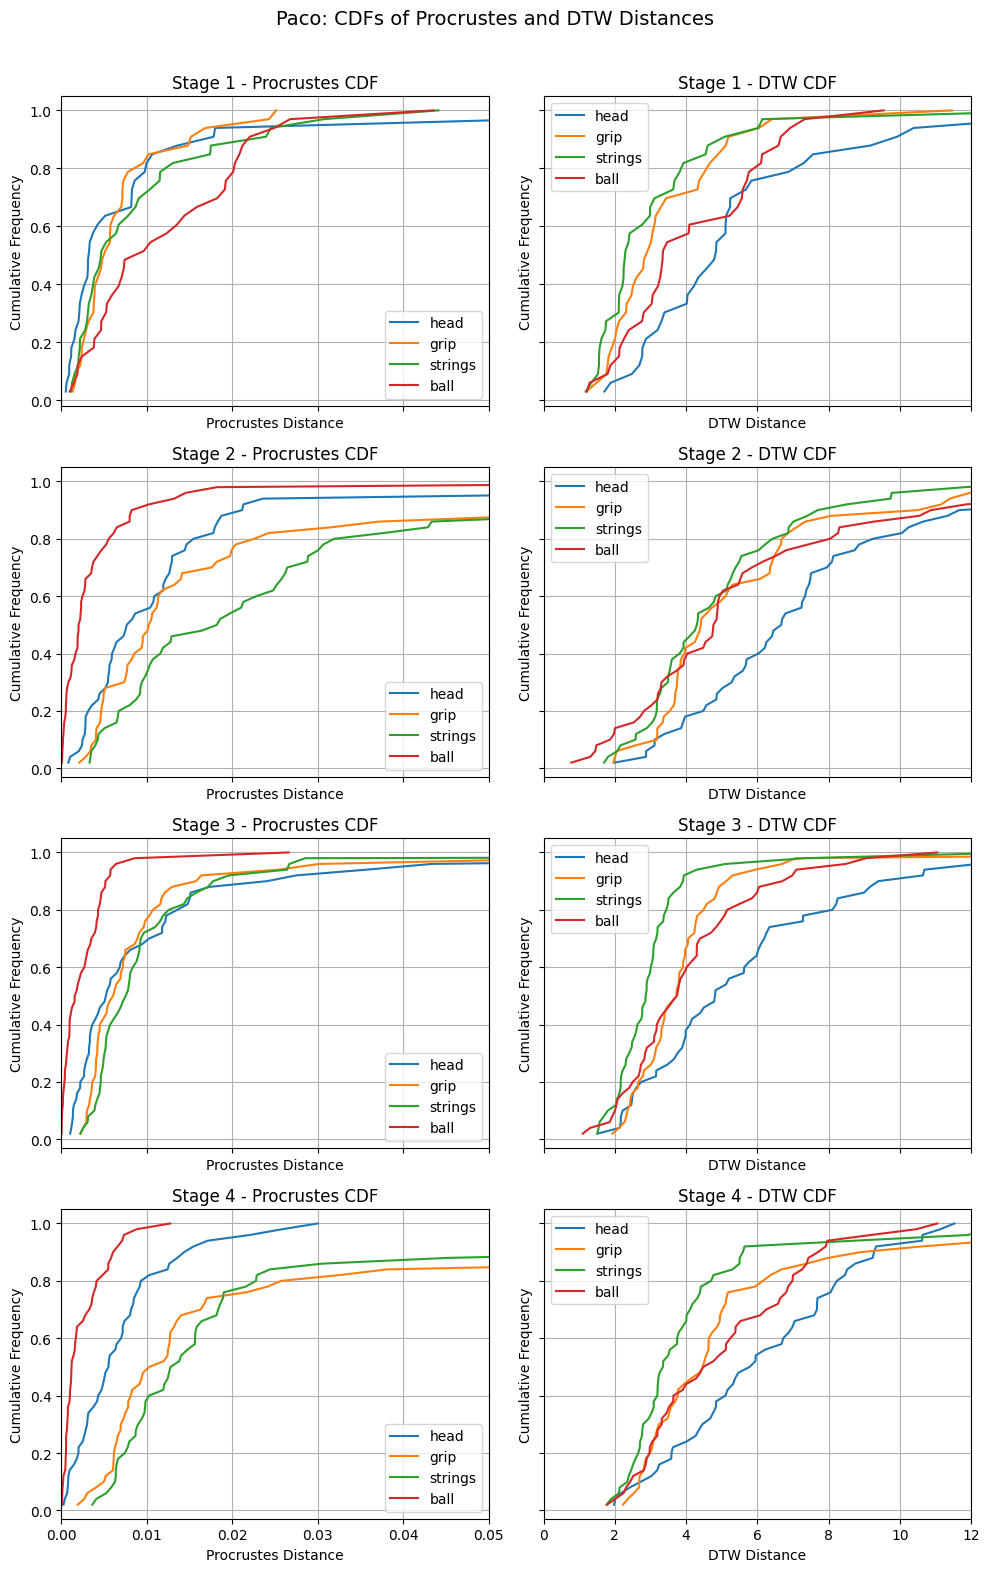

In [345]:
fig, axs = plt.subplots(
    n_stages, 2, figsize=(10, 4 * n_stages), sharex="col", sharey="row"
)
fig.suptitle(
    f"{subject2plot}: CDFs of Procrustes and DTW Distances", fontsize=14, y=0.98
)

for stage in range(1, n_stages + 1):
    for f_idx, label in enumerate(features2compare_labels):
        df_feat = dfs_features[label]
        df_stage = df_feat[df_feat["stage"] == stage]
        alignment_times = df_stage[df_stage["event"] == alignment]["time"].values

        aligned_trajs = []
        for t_align in alignment_times:
            traj = df_stage[
                (df_stage["time"] >= t_align - half_window_duration)
                & (df_stage["time"] <= t_align + half_window_duration)
            ][["position.x", "position.y", "position.z"]].to_numpy()
            if traj.shape[0] == window_size:
                aligned_trajs.append(traj)
        aligned_trajs = np.array(aligned_trajs)

        if aligned_trajs.shape[0] == 0:
            continue

        mean_traj = np.mean(aligned_trajs, axis=0)

        # Procrustes distances
        procrustes_distances = []
        for traj in aligned_trajs:
            _, _, disparity = procrustes(mean_traj, traj)
            procrustes_distances.append(disparity)
        procrustes_distances = np.array(procrustes_distances)
        sorted_procrustes = np.sort(procrustes_distances)
        cdf_procrustes = np.arange(1, len(sorted_procrustes) + 1) / len(
            sorted_procrustes
        )
        axs[stage - 1, 0].plot(
            sorted_procrustes, cdf_procrustes, label=label, color=feature_colors[f_idx]
        )

        # DTW distances
        dtw_distances = []
        for traj in aligned_trajs:
            distance, _ = fastdtw(traj, mean_traj, dist=euclidean)
            dtw_distances.append(distance)
        dtw_distances = np.array(dtw_distances)
        sorted_dtw = np.sort(dtw_distances)
        cdf_dtw = np.arange(1, len(sorted_dtw) + 1) / len(sorted_dtw)
        axs[stage - 1, 1].plot(
            sorted_dtw, cdf_dtw, label=label, color=feature_colors[f_idx]
        )

    axs[stage - 1, 0].set_title(f"Stage {stage} - Procrustes CDF")
    axs[stage - 1, 0].set_xlabel("Procrustes Distance")
    axs[stage - 1, 0].set_ylabel("Cumulative Frequency")
    axs[stage - 1, 0].legend()
    axs[stage - 1, 0].grid()
    axs[stage - 1, 0].set_xlim([0, 0.05])

    axs[stage - 1, 1].set_title(f"Stage {stage} - DTW CDF")
    axs[stage - 1, 1].set_xlabel("DTW Distance")
    axs[stage - 1, 1].set_ylabel("Cumulative Frequency")
    axs[stage - 1, 1].legend()
    axs[stage - 1, 1].grid()
    axs[stage - 1, 1].set_xlim([0, 12])

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()